# General models

Aim to create a range of underfitting, overfitting and fairly well optimised models based on bitcoin dataset.

These models will help give some indication of the effects of adding and removing parameters and hyperparameters and serve as a set of baseline models to work from when optimising each coin for the most effective sets of parameters found.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from helper_functions import *
from datetime import date, timedelta
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop


#Importing the dataset and inspection
current_folder = os.path.abspath('')
bitcoin_csv = os.path.join(current_folder, "data","bitcoin_hourly.csv")
bitcoin_df = pd.read_csv(bitcoin_csv)

# Adding a difference high low as a possible feature to use
# in place of providing high and low seperately
bitcoin_df['highLowDif'] = bitcoin_df['highPriceUsd'] - bitcoin_df['lowPriceUsd']

# converting datetime to datetime format (from stroing) for easierr filtering
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['datetime'], errors='coerce')

# filtering dates to a hundred days from collection start
start_point = bitcoin_df['datetime'][0]
end_point = start_point + timedelta(100)

filter_dates = bitcoin_df['datetime'] >= pd.to_datetime(start_point)
timeperiod_df = bitcoin_df[filter_dates]
filter_dates = timeperiod_df['datetime'] < pd.to_datetime(end_point)
timeperiod_df = timeperiod_df[filter_dates]

In [9]:
# double checking there are no nan values in the timeperiod
print(rows_with_nan_values(timeperiod_df))

[]


In [10]:
bitcoin_df.iloc[0]

datetime                      2021-02-03 00:00:00+00:00
bitcoin_count                                      1557
bitcoin_polarity                               0.198884
bitcoin_subjectivity                           0.503805
bitcoin_polarity_zeros                         0.105064
bitcoin_subjectivity_zeros                     0.303084
openPriceUsd                                    35510.8
closePriceUsd                                   36119.5
highPriceUsd                                    36131.9
lowPriceUsd                                       35444
volume                                      62260118369
marketcap                                  672459334169
highLowDif                                      687.926
Name: 0, dtype: object

In [11]:
timeperiod_df = timeperiod_df.drop(columns=['datetime', 'bitcoin_polarity', 'bitcoin_subjectivity', 'bitcoin_polarity_zeros', 'bitcoin_subjectivity_zeros', 'openPriceUsd',  'marketcap', 'highLowDif', 'bitcoin_count'])

In [12]:
timeperiod_df.iloc[0]

closePriceUsd    3.611949e+04
highPriceUsd     3.613191e+04
lowPriceUsd      3.544398e+04
volume           6.226012e+10
Name: 0, dtype: float64

In [13]:
# setting the training, validation, test split
# there are 2400 samples in the 100 day timeperiod
training_samples = int(len(timeperiod_df) * 0.7) # 1680
validation_samples = int(len(timeperiod_df) * 0.2) # 480
test_samples = int(len(timeperiod_df) * 0.1) # 240

# normalising the data
timeperiod_df = normalise_data(timeperiod_df, training_samples+validation_samples, 0)

# returning factors used to normalise the data (in order to reverse)
mean, std = normalisation_values(timeperiod_df, training_samples+validation_samples, 0)

# setting up sequence batches, how far back is looked and how far forward predictions are made
lookback = 120      # 120 / 24 = 5 days
step = 1            # 1hr step
delay = 24          # predictions 1 day in 'future'
batch_size = 128    

# creating the datasets of batches 
# (note due to) small size of test_dataset and te way the keras method to create timeseries datasets works, it is empty we will remake it
train_dataset, val_dataset, test_dataset = create_datasets(timeperiod_df, 'closePriceUsd', training_samples, validation_samples, lookback, step, delay, batch_size)

#clearing the test dataset
test_dataset = None

# getting the shape of the datasets to pass into model parameters
shape_1, shape_2 = get_dataset_shape(train_dataset)

final sample - training: 2160th, validation: 2160th, test: 2400th
Input shape: (128, 120, 4)
Target shape: (128, 1)


Epoch 1/20
13/13 [==============================] - 5s 287ms/step - loss: 1.3724 - val_loss: 0.5305
Epoch 2/20
13/13 [==============================] - 3s 232ms/step - loss: 0.2539 - val_loss: 0.4810
Epoch 3/20
13/13 [==============================] - 3s 233ms/step - loss: 0.2459 - val_loss: 0.4647
Epoch 4/20
13/13 [==============================] - 3s 245ms/step - loss: 0.2344 - val_loss: 0.4503
Epoch 5/20
13/13 [==============================] - 3s 271ms/step - loss: 0.2264 - val_loss: 0.4706
Epoch 6/20
13/13 [==============================] - 3s 243ms/step - loss: 0.1914 - val_loss: 0.3816
Epoch 7/20
13/13 [==============================] - 3s 243ms/step - loss: 0.2609 - val_loss: 0.4114
Epoch 8/20
13/13 [==============================] - 4s 305ms/step - loss: 0.2113 - val_loss: 0.3170
Epoch 9/20
13/13 [==============================] - 3s 232ms/step - loss: 0.2137 - val_loss: 0.3024
Epoch 10/20
13/13 [==============================] - 3s 237ms/step - loss: 0.1599 - val_loss: 0.2783

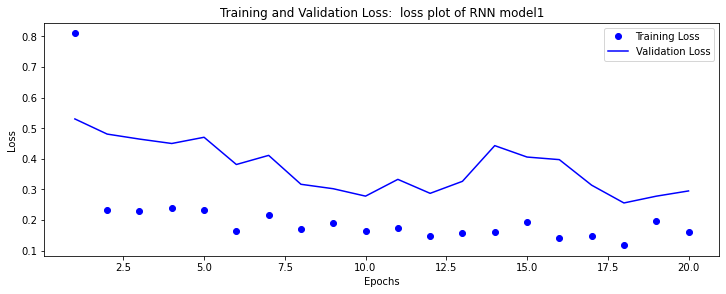

In [14]:
RNN_model1 = models.Sequential()
RNN_model1.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model1.add(layers.SimpleRNN(100))


RNN_model1.add(layers.Dense(1))

RNN_model1.compile(optimizer=RMSprop(), loss='mse')
RNN_model1_history = RNN_model1.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model1_history, "loss plot of RNN model1")

Epoch 1/20
13/13 [==============================] - 5s 287ms/step - loss: 1.9087 - val_loss: 2.0935
Epoch 2/20
13/13 [==============================] - 4s 275ms/step - loss: 0.4363 - val_loss: 1.7793
Epoch 3/20
13/13 [==============================] - 4s 278ms/step - loss: 0.3679 - val_loss: 1.4715
Epoch 4/20
13/13 [==============================] - 3s 270ms/step - loss: 0.3159 - val_loss: 0.9929
Epoch 5/20
13/13 [==============================] - 4s 275ms/step - loss: 0.2500 - val_loss: 0.8640
Epoch 6/20
13/13 [==============================] - 4s 278ms/step - loss: 0.2472 - val_loss: 0.9918
Epoch 7/20
13/13 [==============================] - 4s 274ms/step - loss: 0.2608 - val_loss: 0.9239
Epoch 8/20
13/13 [==============================] - 4s 282ms/step - loss: 0.2261 - val_loss: 0.8853
Epoch 9/20
13/13 [==============================] - 3s 268ms/step - loss: 0.2553 - val_loss: 0.9596
Epoch 10/20
13/13 [==============================] - 3s 266ms/step - loss: 0.2268 - val_loss: 0.7924

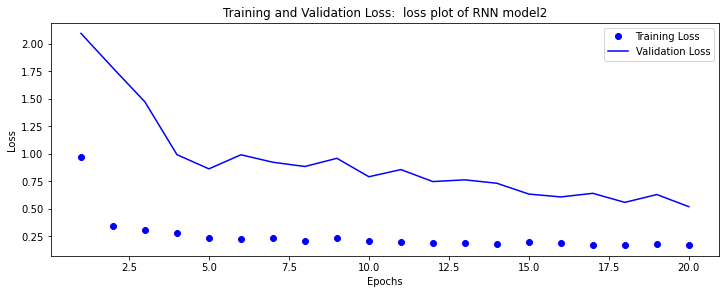

In [15]:
RNN_model2 = models.Sequential()
RNN_model2.add(layers.SimpleRNN(100, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,input_shape=(shape_1, shape_2)))

RNN_model2.add(layers.SimpleRNN(100))


RNN_model2.add(layers.Dense(1))

RNN_model2.compile(optimizer=RMSprop(), loss='mse')
RNN_model2_history = RNN_model2.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model2_history, "loss plot of RNN model2")

Epoch 1/30
13/13 [==============================] - 5s 316ms/step - loss: 1.4169 - val_loss: 0.5750
Epoch 2/30
13/13 [==============================] - 3s 198ms/step - loss: 0.2954 - val_loss: 0.4733
Epoch 3/30
13/13 [==============================] - 3s 194ms/step - loss: 0.2418 - val_loss: 0.4138
Epoch 4/30
13/13 [==============================] - 3s 193ms/step - loss: 0.2166 - val_loss: 0.3834
Epoch 5/30
13/13 [==============================] - 3s 194ms/step - loss: 0.1955 - val_loss: 0.3691
Epoch 6/30
13/13 [==============================] - 3s 237ms/step - loss: 0.1925 - val_loss: 0.3878
Epoch 7/30
13/13 [==============================] - 3s 241ms/step - loss: 0.1732 - val_loss: 0.3180
Epoch 8/30
13/13 [==============================] - 2s 195ms/step - loss: 0.1719 - val_loss: 0.3134
Epoch 9/30
13/13 [==============================] - 2s 190ms/step - loss: 0.1523 - val_loss: 0.2749
Epoch 10/30
13/13 [==============================] - 3s 202ms/step - loss: 0.1750 - val_loss: 0.3077

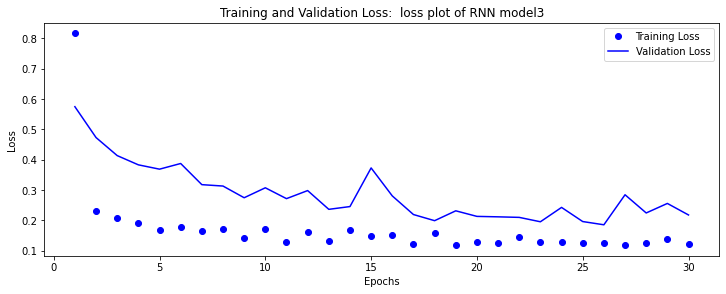

In [16]:
RNN_model3 = models.Sequential()
RNN_model3.add(layers.SimpleRNN(100, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model3.add(layers.SimpleRNN(50))


RNN_model3.add(layers.Dense(1))

RNN_model3.compile(optimizer=RMSprop(), loss='mse')
RNN_model3_history = RNN_model3.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model3_history, "loss plot of RNN model3")

Epoch 1/30
13/13 [==============================] - 5s 248ms/step - loss: 1.0056 - val_loss: 2.2392
Epoch 2/30
13/13 [==============================] - 3s 255ms/step - loss: 0.4310 - val_loss: 1.4913
Epoch 3/30
13/13 [==============================] - 3s 223ms/step - loss: 0.2792 - val_loss: 1.0924
Epoch 4/30
13/13 [==============================] - 3s 238ms/step - loss: 0.2749 - val_loss: 0.8630
Epoch 5/30
13/13 [==============================] - 3s 240ms/step - loss: 0.2422 - val_loss: 0.7207
Epoch 6/30
13/13 [==============================] - 3s 227ms/step - loss: 0.2356 - val_loss: 0.7999
Epoch 7/30
13/13 [==============================] - 3s 229ms/step - loss: 0.2299 - val_loss: 0.6036
Epoch 8/30
13/13 [==============================] - 3s 237ms/step - loss: 0.2024 - val_loss: 0.6215
Epoch 9/30
13/13 [==============================] - 3s 266ms/step - loss: 0.2078 - val_loss: 0.7379
Epoch 10/30
13/13 [==============================] - 4s 288ms/step - loss: 0.2074 - val_loss: 0.5817

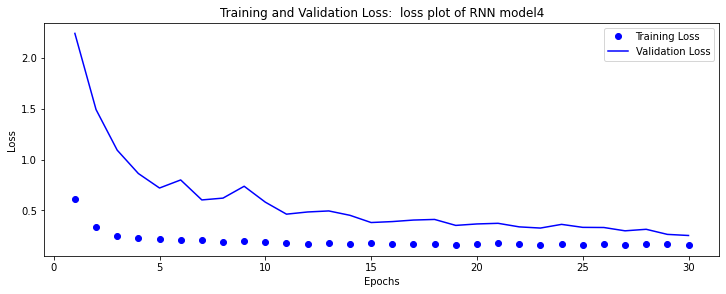

In [17]:
RNN_model4 = models.Sequential()
RNN_model4.add(layers.SimpleRNN(100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model4.add(layers.SimpleRNN(50))


RNN_model4.add(layers.Dense(1))

RNN_model4.compile(optimizer=RMSprop(), loss='mse')
RNN_model4_history = RNN_model4.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model4_history, "loss plot of RNN model4")

Epoch 1/30
13/13 [==============================] - 4s 230ms/step - loss: 0.7963 - val_loss: 0.3534
Epoch 2/30
13/13 [==============================] - 2s 158ms/step - loss: 0.1947 - val_loss: 0.3463
Epoch 3/30
13/13 [==============================] - 2s 158ms/step - loss: 0.1814 - val_loss: 0.3570
Epoch 4/30
13/13 [==============================] - 3s 222ms/step - loss: 0.1727 - val_loss: 0.3576
Epoch 5/30
13/13 [==============================] - 2s 151ms/step - loss: 0.1675 - val_loss: 0.3597
Epoch 6/30
13/13 [==============================] - 2s 161ms/step - loss: 0.1596 - val_loss: 0.3454
Epoch 7/30
13/13 [==============================] - 3s 207ms/step - loss: 0.1540 - val_loss: 0.3347
Epoch 8/30
13/13 [==============================] - 2s 175ms/step - loss: 0.1493 - val_loss: 0.3155
Epoch 9/30
13/13 [==============================] - 2s 161ms/step - loss: 0.1425 - val_loss: 0.3170
Epoch 10/30
13/13 [==============================] - 2s 156ms/step - loss: 0.1395 - val_loss: 0.3215

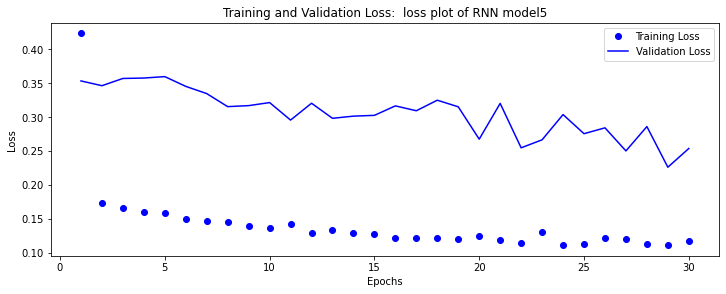

In [18]:
RNN_model5 = models.Sequential()
RNN_model5.add(layers.SimpleRNN(50, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model5.add(layers.SimpleRNN(50))


RNN_model5.add(layers.Dense(1))

RNN_model5.compile(optimizer=RMSprop(), loss='mse')
RNN_model5_history = RNN_model5.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model5_history, "loss plot of RNN model5")

Epoch 1/30
13/13 [==============================] - 4s 208ms/step - loss: 1.4846 - val_loss: 1.5189
Epoch 2/30
13/13 [==============================] - 2s 193ms/step - loss: 0.3904 - val_loss: 1.2904
Epoch 3/30
13/13 [==============================] - 2s 175ms/step - loss: 0.3113 - val_loss: 0.8990
Epoch 4/30
13/13 [==============================] - 2s 183ms/step - loss: 0.2656 - val_loss: 0.9852
Epoch 5/30
13/13 [==============================] - 2s 185ms/step - loss: 0.2430 - val_loss: 1.0597
Epoch 6/30
13/13 [==============================] - 2s 172ms/step - loss: 0.2446 - val_loss: 0.8363
Epoch 7/30
13/13 [==============================] - 2s 191ms/step - loss: 0.2248 - val_loss: 0.7350
Epoch 8/30
13/13 [==============================] - 2s 184ms/step - loss: 0.2163 - val_loss: 0.7724
Epoch 9/30
13/13 [==============================] - 2s 184ms/step - loss: 0.2078 - val_loss: 0.6584
Epoch 10/30
13/13 [==============================] - 2s 171ms/step - loss: 0.2052 - val_loss: 0.6393

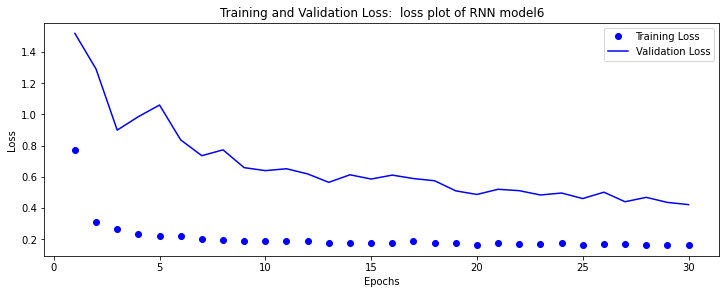

In [19]:
RNN_model6 = models.Sequential()
RNN_model6.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model6.add(layers.SimpleRNN(50))


RNN_model6.add(layers.Dense(1))

RNN_model6.compile(optimizer=RMSprop(), loss='mse')
RNN_model6_history = RNN_model6.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model6_history, "loss plot of RNN model6")

Epoch 1/40
13/13 [==============================] - 4s 186ms/step - loss: 1.0699 - val_loss: 0.5964
Epoch 2/40
13/13 [==============================] - 2s 143ms/step - loss: 0.2266 - val_loss: 0.4791
Epoch 3/40
13/13 [==============================] - 2s 148ms/step - loss: 0.2019 - val_loss: 0.4405
Epoch 4/40
13/13 [==============================] - 2s 149ms/step - loss: 0.1907 - val_loss: 0.4118
Epoch 5/40
13/13 [==============================] - 2s 145ms/step - loss: 0.1790 - val_loss: 0.3840
Epoch 6/40
13/13 [==============================] - 2s 141ms/step - loss: 0.1694 - val_loss: 0.3546
Epoch 7/40
13/13 [==============================] - 2s 148ms/step - loss: 0.1617 - val_loss: 0.3285
Epoch 8/40
13/13 [==============================] - 2s 152ms/step - loss: 0.1540 - val_loss: 0.3159
Epoch 9/40
13/13 [==============================] - 2s 151ms/step - loss: 0.1471 - val_loss: 0.3138
Epoch 10/40
13/13 [==============================] - 2s 148ms/step - loss: 0.1425 - val_loss: 0.3042

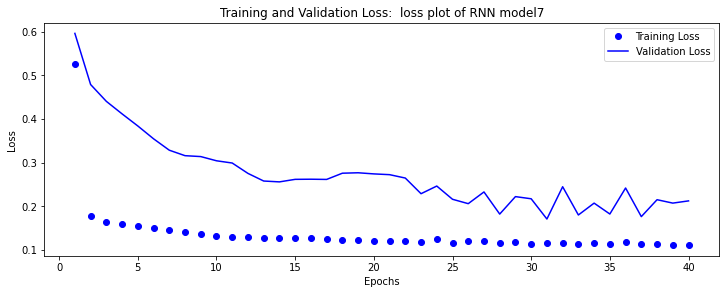

In [20]:
RNN_model7 = models.Sequential()
RNN_model7.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model7.add(layers.SimpleRNN(32))


RNN_model7.add(layers.Dense(1))

RNN_model7.compile(optimizer=RMSprop(), loss='mse')
RNN_model7_history = RNN_model7.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model7_history, "loss plot of RNN model7")

Epoch 1/30
13/13 [==============================] - 4s 197ms/step - loss: 0.4857 - val_loss: 0.8590
Epoch 2/30
13/13 [==============================] - 2s 152ms/step - loss: 0.3367 - val_loss: 0.6999
Epoch 3/30
13/13 [==============================] - 2s 160ms/step - loss: 0.2895 - val_loss: 0.6062
Epoch 4/30
13/13 [==============================] - 2s 164ms/step - loss: 0.2645 - val_loss: 0.5514
Epoch 5/30
13/13 [==============================] - 2s 167ms/step - loss: 0.2560 - val_loss: 0.4715
Epoch 6/30
13/13 [==============================] - 2s 153ms/step - loss: 0.2342 - val_loss: 0.4901
Epoch 7/30
13/13 [==============================] - 2s 166ms/step - loss: 0.2155 - val_loss: 0.4701
Epoch 8/30
13/13 [==============================] - 2s 164ms/step - loss: 0.2187 - val_loss: 0.4774
Epoch 9/30
13/13 [==============================] - 2s 151ms/step - loss: 0.2101 - val_loss: 0.4981
Epoch 10/30
13/13 [==============================] - 2s 159ms/step - loss: 0.1986 - val_loss: 0.3938

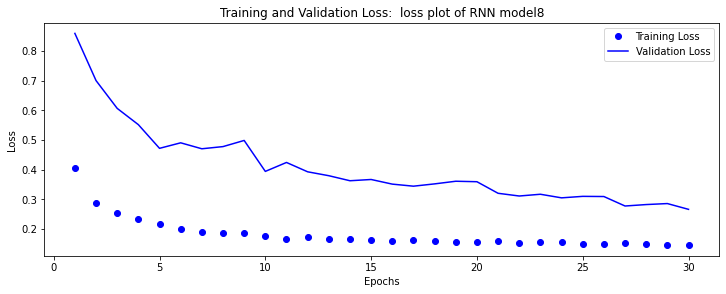

In [21]:
RNN_model8 = models.Sequential()
RNN_model8.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model8.add(layers.SimpleRNN(32))


RNN_model8.add(layers.Dense(1))

RNN_model8.compile(optimizer=RMSprop(), loss='mse')
RNN_model8_history = RNN_model8.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model8_history, "loss plot of RNN model8")

Epoch 1/20
13/13 [==============================] - 4s 172ms/step - loss: 0.3847 - val_loss: 0.3012
Epoch 2/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1663 - val_loss: 0.2690
Epoch 3/20
13/13 [==============================] - 2s 147ms/step - loss: 0.1526 - val_loss: 0.2595
Epoch 4/20
13/13 [==============================] - 2s 130ms/step - loss: 0.1467 - val_loss: 0.2512
Epoch 5/20
13/13 [==============================] - 2s 134ms/step - loss: 0.1433 - val_loss: 0.2447
Epoch 6/20
13/13 [==============================] - 2s 146ms/step - loss: 0.1415 - val_loss: 0.2385
Epoch 7/20
13/13 [==============================] - 2s 144ms/step - loss: 0.1401 - val_loss: 0.2312
Epoch 8/20
13/13 [==============================] - 2s 179ms/step - loss: 0.1386 - val_loss: 0.2238
Epoch 9/20
13/13 [==============================] - 2s 142ms/step - loss: 0.1371 - val_loss: 0.2172
Epoch 10/20
13/13 [==============================] - 2s 150ms/step - loss: 0.1354 - val_loss: 0.2115

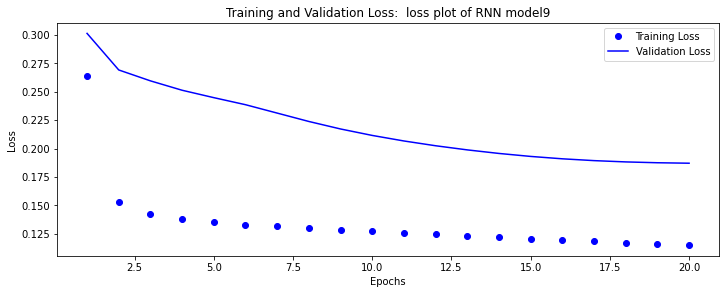

In [22]:
RNN_model9 = models.Sequential()
RNN_model9.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model9.add(layers.SimpleRNN(16))


RNN_model9.add(layers.Dense(1))

RNN_model9.compile(optimizer=RMSprop(), loss='mse')
RNN_model9_history = RNN_model9.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model9_history, "loss plot of RNN model9")

Epoch 1/20
13/13 [==============================] - 4s 195ms/step - loss: 0.6344 - val_loss: 0.6641
Epoch 2/20
13/13 [==============================] - 2s 159ms/step - loss: 0.3103 - val_loss: 0.4703
Epoch 3/20
13/13 [==============================] - 2s 164ms/step - loss: 0.2629 - val_loss: 0.3627
Epoch 4/20
13/13 [==============================] - 2s 163ms/step - loss: 0.2246 - val_loss: 0.3524
Epoch 5/20
13/13 [==============================] - 2s 190ms/step - loss: 0.2246 - val_loss: 0.3401
Epoch 6/20
13/13 [==============================] - 2s 162ms/step - loss: 0.1911 - val_loss: 0.3400
Epoch 7/20
13/13 [==============================] - 3s 201ms/step - loss: 0.1806 - val_loss: 0.3363
Epoch 8/20
13/13 [==============================] - 2s 159ms/step - loss: 0.1868 - val_loss: 0.3039
Epoch 9/20
13/13 [==============================] - 3s 201ms/step - loss: 0.1736 - val_loss: 0.2853
Epoch 10/20
13/13 [==============================] - 2s 160ms/step - loss: 0.1714 - val_loss: 0.2891

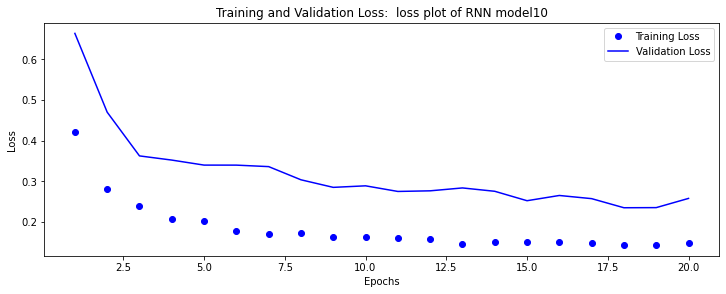

In [23]:
RNN_model10 = models.Sequential()
RNN_model10.add(layers.SimpleRNN(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model10.add(layers.SimpleRNN(16))

RNN_model10.add(layers.Dense(1))

RNN_model10.compile(optimizer=RMSprop(), loss='mse')
RNN_model10_history = RNN_model10.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model10_history, "loss plot of RNN model10")

Epoch 1/40
13/13 [==============================] - 4s 172ms/step - loss: 0.6635 - val_loss: 0.1405
Epoch 2/40
13/13 [==============================] - 2s 134ms/step - loss: 0.4049 - val_loss: 0.1840
Epoch 3/40
13/13 [==============================] - 2s 152ms/step - loss: 0.2947 - val_loss: 0.2259
Epoch 4/40
13/13 [==============================] - 2s 151ms/step - loss: 0.2457 - val_loss: 0.2627
Epoch 5/40
13/13 [==============================] - 2s 144ms/step - loss: 0.2292 - val_loss: 0.2914
Epoch 6/40
13/13 [==============================] - 2s 157ms/step - loss: 0.2056 - val_loss: 0.3079
Epoch 7/40
13/13 [==============================] - 2s 146ms/step - loss: 0.2042 - val_loss: 0.3183
Epoch 8/40
13/13 [==============================] - 2s 158ms/step - loss: 0.1959 - val_loss: 0.3253
Epoch 9/40
13/13 [==============================] - 2s 170ms/step - loss: 0.1932 - val_loss: 0.3259
Epoch 10/40
13/13 [==============================] - 2s 156ms/step - loss: 0.1911 - val_loss: 0.3253

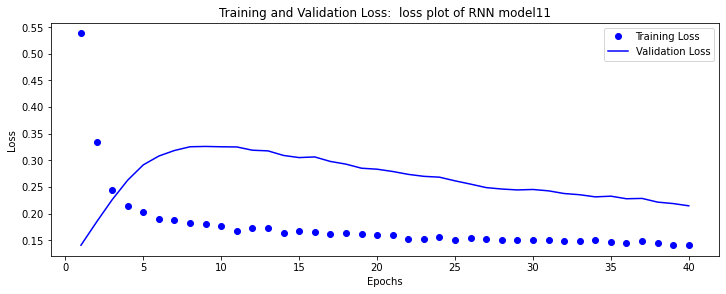

In [24]:
RNN_model11 = models.Sequential()
RNN_model11.add(layers.SimpleRNN(10, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model11.add(layers.SimpleRNN(5))


RNN_model11.add(layers.Dense(1))

RNN_model11.compile(optimizer=RMSprop(), loss='mse')
RNN_model11_history = RNN_model11.fit(train_dataset, epochs=40, validation_data=val_dataset)

plot_simple_loss(RNN_model11_history, "loss plot of RNN model11")

Epoch 1/30
13/13 [==============================] - 7s 268ms/step - loss: 0.9459 - val_loss: 1.3762
Epoch 2/30
13/13 [==============================] - 3s 238ms/step - loss: 0.3790 - val_loss: 1.0763
Epoch 3/30
13/13 [==============================] - 3s 233ms/step - loss: 0.3311 - val_loss: 1.0307
Epoch 4/30
13/13 [==============================] - 3s 232ms/step - loss: 0.3216 - val_loss: 0.9254
Epoch 5/30
13/13 [==============================] - 3s 244ms/step - loss: 0.2877 - val_loss: 0.9263
Epoch 6/30
13/13 [==============================] - 3s 237ms/step - loss: 0.2573 - val_loss: 0.8791
Epoch 7/30
13/13 [==============================] - 3s 240ms/step - loss: 0.2484 - val_loss: 1.0041
Epoch 8/30
13/13 [==============================] - 3s 248ms/step - loss: 0.2337 - val_loss: 0.8985
Epoch 9/30
13/13 [==============================] - 3s 241ms/step - loss: 0.2518 - val_loss: 0.8116
Epoch 10/30
13/13 [==============================] - 3s 247ms/step - loss: 0.2310 - val_loss: 0.7728

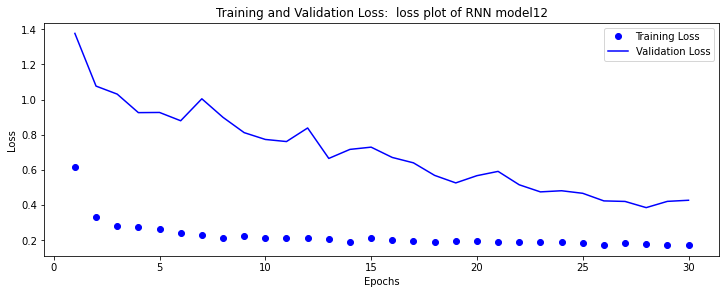

In [25]:
RNN_model12 = models.Sequential()
RNN_model12.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model12.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))

RNN_model12.add(layers.SimpleRNN(50))


RNN_model12.add(layers.Dense(1))

RNN_model12.compile(optimizer=RMSprop(), loss='mse')
RNN_model12_history = RNN_model12.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model12_history, "loss plot of RNN model12")

Epoch 1/30
13/13 [==============================] - 8s 401ms/step - loss: 0.9307 - val_loss: 1.9717
Epoch 2/30
13/13 [==============================] - 4s 294ms/step - loss: 0.4647 - val_loss: 1.4228
Epoch 3/30
13/13 [==============================] - 4s 304ms/step - loss: 0.3413 - val_loss: 1.7167
Epoch 4/30
13/13 [==============================] - 4s 294ms/step - loss: 0.2969 - val_loss: 1.6381
Epoch 5/30
13/13 [==============================] - 4s 295ms/step - loss: 0.2916 - val_loss: 1.2141
Epoch 6/30
13/13 [==============================] - 4s 302ms/step - loss: 0.2809 - val_loss: 1.2656
Epoch 7/30
13/13 [==============================] - 4s 323ms/step - loss: 0.2625 - val_loss: 1.0011
Epoch 8/30
13/13 [==============================] - 4s 296ms/step - loss: 0.2727 - val_loss: 1.0529
Epoch 9/30
13/13 [==============================] - 4s 304ms/step - loss: 0.2761 - val_loss: 1.2063
Epoch 10/30
13/13 [==============================] - 4s 298ms/step - loss: 0.2488 - val_loss: 1.2409

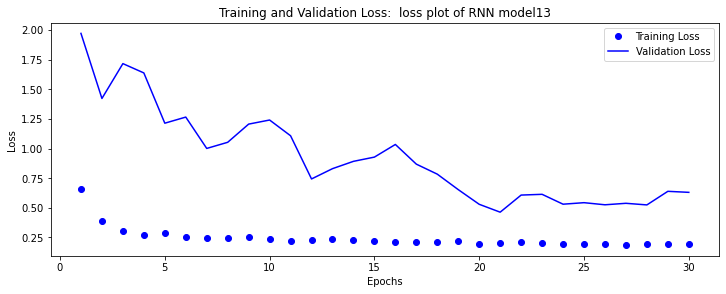

In [26]:
RNN_model13 = models.Sequential()
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(shape_1, shape_2)))

RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
RNN_model13.add(layers.SimpleRNN(50))


RNN_model13.add(layers.Dense(1))

RNN_model13.compile(optimizer=RMSprop(), loss='mse')
RNN_model13_history = RNN_model13.fit(train_dataset, epochs=30, validation_data=val_dataset)

plot_simple_loss(RNN_model13_history, "loss plot of RNN model13")

Epoch 1/20
13/13 [==============================] - 5s 208ms/step - loss: 0.7177 - val_loss: 0.5017
Epoch 2/20
13/13 [==============================] - 2s 175ms/step - loss: 0.2207 - val_loss: 0.4018
Epoch 3/20
13/13 [==============================] - 2s 163ms/step - loss: 0.2022 - val_loss: 0.3685
Epoch 4/20
13/13 [==============================] - 2s 155ms/step - loss: 0.1874 - val_loss: 0.3451
Epoch 5/20
13/13 [==============================] - 2s 161ms/step - loss: 0.1756 - val_loss: 0.3233
Epoch 6/20
13/13 [==============================] - 2s 174ms/step - loss: 0.1678 - val_loss: 0.3084
Epoch 7/20
13/13 [==============================] - 2s 153ms/step - loss: 0.1604 - val_loss: 0.2950
Epoch 8/20
13/13 [==============================] - 3s 262ms/step - loss: 0.1544 - val_loss: 0.2812
Epoch 9/20
13/13 [==============================] - 2s 150ms/step - loss: 0.1503 - val_loss: 0.2645
Epoch 10/20
13/13 [==============================] - 2s 148ms/step - loss: 0.1451 - val_loss: 0.2546

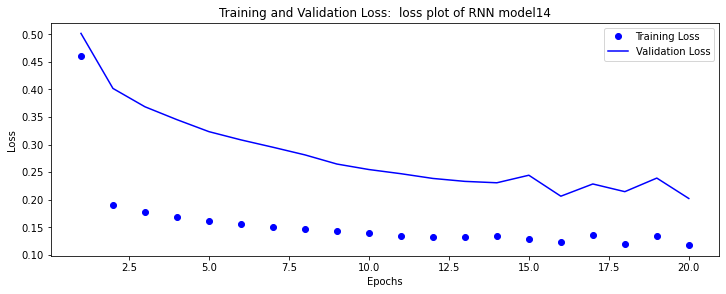

In [27]:
RNN_model14 = models.Sequential()
RNN_model14.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model14.add(layers.SimpleRNN(32))

RNN_model14.add(layers.Dense(1))

RNN_model14.compile(optimizer=RMSprop(), loss='mse')
RNN_model14_history = RNN_model14.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model14_history, "loss plot of RNN model14")

Epoch 1/20
13/13 [==============================] - 7s 273ms/step - loss: 0.2899 - val_loss: 0.1837
Epoch 2/20
13/13 [==============================] - 2s 145ms/step - loss: 0.1809 - val_loss: 0.1986
Epoch 3/20
13/13 [==============================] - 2s 161ms/step - loss: 0.1741 - val_loss: 0.1943
Epoch 4/20
13/13 [==============================] - 2s 158ms/step - loss: 0.1669 - val_loss: 0.1885
Epoch 5/20
13/13 [==============================] - 3s 223ms/step - loss: 0.1606 - val_loss: 0.1839
Epoch 6/20
13/13 [==============================] - 3s 197ms/step - loss: 0.1554 - val_loss: 0.1805
Epoch 7/20
13/13 [==============================] - 2s 163ms/step - loss: 0.1512 - val_loss: 0.1780
Epoch 8/20
13/13 [==============================] - 2s 179ms/step - loss: 0.1478 - val_loss: 0.1762
Epoch 9/20
13/13 [==============================] - 3s 200ms/step - loss: 0.1451 - val_loss: 0.1749
Epoch 10/20
13/13 [==============================] - 2s 158ms/step - loss: 0.1429 - val_loss: 0.1738

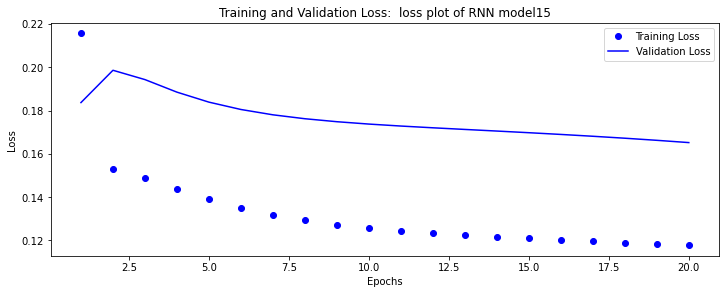

In [28]:
RNN_model15 = models.Sequential()
RNN_model15.add(layers.SimpleRNN(16, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model15.add(layers.SimpleRNN(16))

RNN_model15.add(layers.Dense(1))

RNN_model15.compile(optimizer=RMSprop(), loss='mse')
RNN_model15_history = RNN_model15.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model15_history, "loss plot of RNN model15")

Epoch 1/20
13/13 [==============================] - 4s 180ms/step - loss: 0.8959 - val_loss: 0.5328
Epoch 2/20
13/13 [==============================] - 2s 148ms/step - loss: 0.2443 - val_loss: 0.5471
Epoch 3/20
13/13 [==============================] - 3s 225ms/step - loss: 0.2148 - val_loss: 0.5271
Epoch 4/20
13/13 [==============================] - 2s 153ms/step - loss: 0.1974 - val_loss: 0.5558
Epoch 5/20
13/13 [==============================] - 2s 187ms/step - loss: 0.1879 - val_loss: 0.5408
Epoch 6/20
13/13 [==============================] - 3s 210ms/step - loss: 0.1783 - val_loss: 0.5152
Epoch 7/20
13/13 [==============================] - 2s 165ms/step - loss: 0.1708 - val_loss: 0.4943
Epoch 8/20
13/13 [==============================] - 2s 173ms/step - loss: 0.1648 - val_loss: 0.4714
Epoch 9/20
13/13 [==============================] - 2s 164ms/step - loss: 0.1590 - val_loss: 0.4484
Epoch 10/20
13/13 [==============================] - 2s 155ms/step - loss: 0.1530 - val_loss: 0.3880

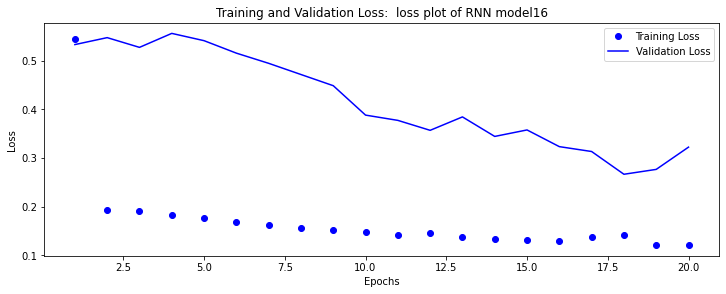

In [29]:
RNN_model16 = models.Sequential()
RNN_model16.add(layers.SimpleRNN(64, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model16.add(layers.SimpleRNN(64))

RNN_model16.add(layers.Dense(1))

RNN_model16.compile(optimizer=RMSprop(), loss='mse')
RNN_model16_history = RNN_model16.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model16_history, "loss plot of RNN model16")

Epoch 1/20
13/13 [==============================] - 7s 318ms/step - loss: 0.7304 - val_loss: 0.8485
Epoch 2/20
13/13 [==============================] - 3s 221ms/step - loss: 0.2863 - val_loss: 0.7412
Epoch 3/20
13/13 [==============================] - 2s 184ms/step - loss: 0.2630 - val_loss: 0.6444
Epoch 4/20
13/13 [==============================] - 3s 226ms/step - loss: 0.2301 - val_loss: 0.5541
Epoch 5/20
13/13 [==============================] - 2s 182ms/step - loss: 0.2144 - val_loss: 0.5071
Epoch 6/20
13/13 [==============================] - 3s 194ms/step - loss: 0.2049 - val_loss: 0.4707
Epoch 7/20
13/13 [==============================] - 2s 192ms/step - loss: 0.1944 - val_loss: 0.4356
Epoch 8/20
13/13 [==============================] - 3s 212ms/step - loss: 0.1857 - val_loss: 0.4017
Epoch 9/20
13/13 [==============================] - 2s 190ms/step - loss: 0.1946 - val_loss: 0.3667
Epoch 10/20
13/13 [==============================] - 2s 189ms/step - loss: 0.1697 - val_loss: 0.3418

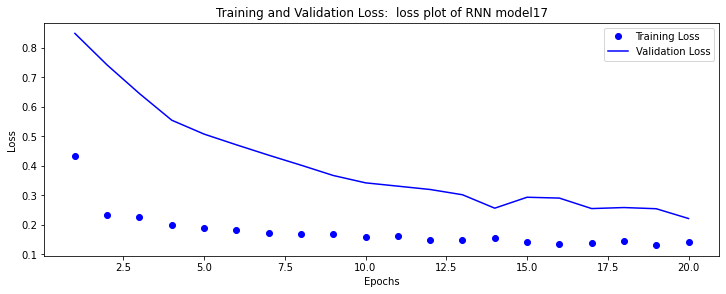

In [30]:
RNN_model17 = models.Sequential()
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model17.add(layers.SimpleRNN(32))
RNN_model17.add(layers.Dense(1))

RNN_model17.compile(optimizer=RMSprop(), loss='mse')
RNN_model17_history = RNN_model17.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model17_history, "loss plot of RNN model17")

Epoch 1/20
13/13 [==============================] - 5s 253ms/step - loss: 1.1341 - val_loss: 0.4939
Epoch 2/20
13/13 [==============================] - 2s 162ms/step - loss: 0.2726 - val_loss: 0.4293
Epoch 3/20
13/13 [==============================] - 2s 165ms/step - loss: 0.2514 - val_loss: 0.3836
Epoch 4/20
13/13 [==============================] - 2s 160ms/step - loss: 0.2350 - val_loss: 0.3540
Epoch 5/20
13/13 [==============================] - 2s 166ms/step - loss: 0.2222 - val_loss: 0.3324
Epoch 6/20
13/13 [==============================] - 2s 153ms/step - loss: 0.2120 - val_loss: 0.3162
Epoch 7/20
13/13 [==============================] - 2s 172ms/step - loss: 0.2025 - val_loss: 0.3060
Epoch 8/20
13/13 [==============================] - 2s 169ms/step - loss: 0.1934 - val_loss: 0.3010
Epoch 9/20
13/13 [==============================] - 2s 171ms/step - loss: 0.1854 - val_loss: 0.2989
Epoch 10/20
13/13 [==============================] - 4s 283ms/step - loss: 0.1786 - val_loss: 0.2979

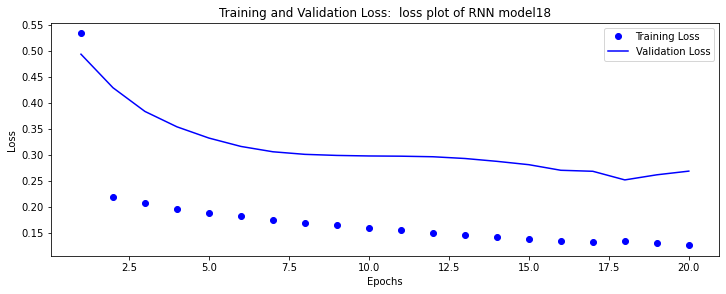

In [31]:
RNN_model18 = models.Sequential()
RNN_model18.add(layers.SimpleRNN(32, return_sequences=True, input_shape=(shape_1, shape_2)))

RNN_model18.add(layers.SimpleRNN(32, return_sequences=True))
RNN_model18.add(layers.SimpleRNN(32))

RNN_model18.add(layers.Dense(1))

RNN_model18.compile(optimizer=RMSprop(), loss='mse')
RNN_model18_history = RNN_model18.fit(train_dataset, epochs=20, validation_data=val_dataset)

plot_simple_loss(RNN_model18_history, "loss plot of RNN model18")

In [32]:
histories = [RNN_model1_history, RNN_model2_history, RNN_model3_history, RNN_model4_history, RNN_model5_history, RNN_model6_history, RNN_model7_history, RNN_model8_history, RNN_model9_history, RNN_model10_history, RNN_model11_history, RNN_model12_history, RNN_model13_history, RNN_model14_history, RNN_model15_history, RNN_model16_history, RNN_model17_history, RNN_model18_history]

for i in range(0, len(histories)):
    val_loss, epoch = lowest_val_loss_and_epoch(histories[i])
    print(f"Model {i+1}: min val loss: {val_loss}, epoch: {epoch}")

Model 1: min val loss: 0.2559676468372345, epoch: 18
Model 2: min val loss: 0.5206594467163086, epoch: 20
Model 3: min val loss: 0.18575726449489594, epoch: 26
Model 4: min val loss: 0.2543983459472656, epoch: 30
Model 5: min val loss: 0.22617247700691223, epoch: 29
Model 6: min val loss: 0.42134329676628113, epoch: 30
Model 7: min val loss: 0.17057223618030548, epoch: 31
Model 8: min val loss: 0.26586994528770447, epoch: 30
Model 9: min val loss: 0.1871146857738495, epoch: 20
Model 10: min val loss: 0.23513393104076385, epoch: 18
Model 11: min val loss: 0.14046800136566162, epoch: 1
Model 12: min val loss: 0.38484513759613037, epoch: 28
Model 13: min val loss: 0.4633634686470032, epoch: 21
Model 14: min val loss: 0.2019982784986496, epoch: 20
Model 15: min val loss: 0.16521130502223969, epoch: 20
Model 16: min val loss: 0.2665794789791107, epoch: 18
Model 17: min val loss: 0.22080926597118378, epoch: 20
Model 18: min val loss: 0.25178536772727966, epoch: 18
